In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd

In [48]:
df = pd.read_csv('../data/cleaning.csv')

In [49]:
y = df['is_default']
X = df.drop("is_default", axis=1)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.90, random_state=0, stratify=y)

cat_var = ['State','BankState','NewExist', 'UrbanRural', 'sector']
num_var = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'RevLineCr', 'LowDoc', 'have_franchise', 'in_recession']

cat_transformer = OneHotEncoder(handle_unknown='ignore')

num_transformer = RobustScaler()

encoder = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var),
        ('num', num_transformer, num_var)
    ], 
    #remainder= "passthrough"
)
pipeline = Pipeline([
    ('enc', encoder),
    ('model', RandomForestClassifier(n_estimators=100 ,min_samples_split=250, random_state=42)),
])

In [51]:
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=3)

In [52]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95    490318
           1       0.87      0.68      0.77    123271

    accuracy                           0.92    613589
   macro avg       0.90      0.83      0.86    613589
weighted avg       0.91      0.92      0.91    613589



In [53]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'NewExist', 'UrbanRural',
                                                   'sector']),
                                                 ('num', RobustScaler(),
                                                  ['Term', 'NoEmp', 'CreateJob',
                                                   'RetainedJob', 'RevLineCr',
                                                   'LowDoc', 'have_franchise',
                                                   'in_recession'])])),
                ('model',
                 RandomForestClassifier(min_samples_split=250,
                                        random_state=42))])

In [54]:
pipeline.score(X_test, y_test)

0.9198410020974815

In [55]:
print(classification_report(y_test, pipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     54480
           1       0.87      0.70      0.78     13697

    accuracy                           0.92     68177
   macro avg       0.90      0.84      0.87     68177
weighted avg       0.92      0.92      0.92     68177



In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681766 entries, 0 to 681765
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   State           681766 non-null  object 
 1   BankState       681766 non-null  object 
 2   Term            681766 non-null  float64
 3   NoEmp           681766 non-null  float64
 4   NewExist        681766 non-null  object 
 5   CreateJob       681766 non-null  int64  
 6   RetainedJob     681766 non-null  int64  
 7   UrbanRural      681766 non-null  object 
 8   RevLineCr       681766 non-null  int64  
 9   LowDoc          681766 non-null  int64  
 10  GrAppv          681766 non-null  float64
 11  is_default      681766 non-null  int64  
 12  have_franchise  681766 non-null  int64  
 13  sector          681766 non-null  object 
 14  in_recession    681766 non-null  int64  
dtypes: float64(3), int64(7), object(5)
memory usage: 78.0+ MB


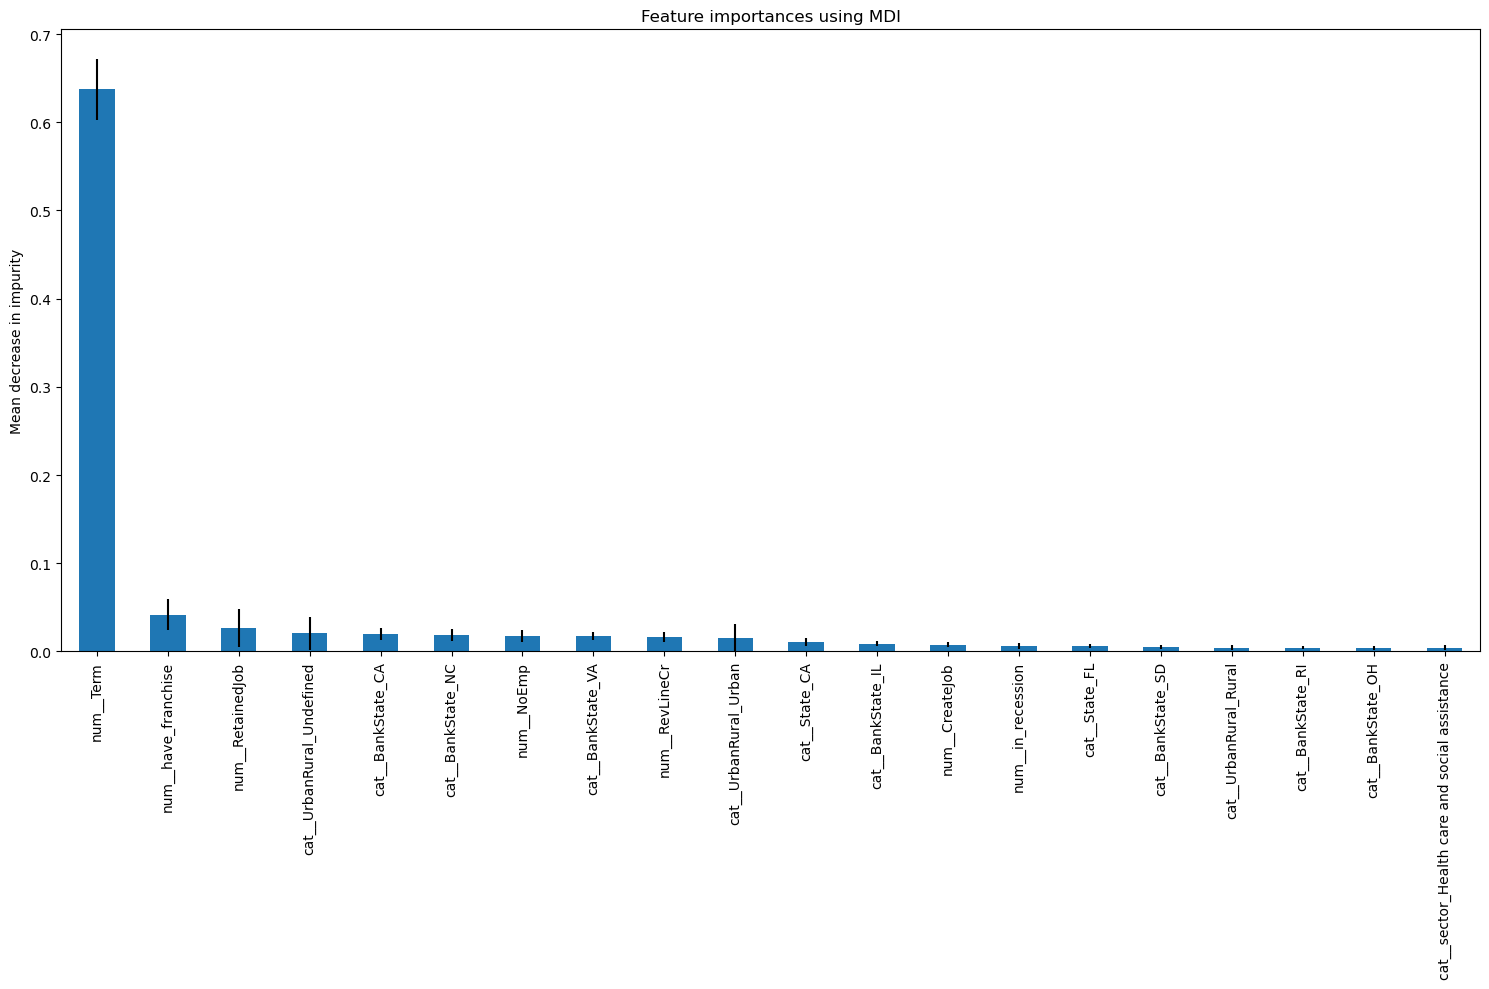

In [67]:
importances = pipeline[-1].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipeline[-1].estimators_], axis=0)

forest_importances = pd.DataFrame({"feature_importances":importances,"std":std},index=pipeline[0].get_feature_names_out())
forest_importances.sort_values(by="feature_importances",ascending=False,inplace=True)
forest_importances = forest_importances.head(20)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances["feature_importances"].plot.bar(yerr=forest_importances["std"], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()